In [2]:
# Must be included at the beginning of each notebook. Remember to change the app name. 
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark

# Create SparkSession and giving it an appname
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data_preparation').getOrCreate()

import warnings
warnings.simplefilter(action='ignore')

In [3]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer 
import seaborn as sns

from pyspark.sql import Window

In [5]:
# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data.show(5, truncate=15)

+---+----------+-----------+----------+--------+---------+---------+----------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [31]:
data.filter((data['Age']==-9999999) | (data['Age']==1000) | (data['heartRate']==7)).show()

+--------+----------+-----------+----------+--------+---------+---------+----------+
|     Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+--------+----------+-----------+----------+--------+---------+---------+----------+
|-9999999|       110|         65|       7.1|    96.0|       70| low risk|no comment|
|    1000|       110|         65|       7.1|    96.0|       70| low risk|no comment|
|      16|       120|         75|       7.9|    98.0|        7| low risk|no comment|
|      16|       120|         75|       7.9|    98.0|        7| low risk|no comment|
+--------+----------+-----------+----------+--------+---------+---------+----------+



In [32]:
# drop the 'comment' column    
data=data.drop('comment')
data.show()

+---+----------+-----------+----------+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+---+----------+-----------+----------+--------+---------+---------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|
| 35|       140|         90|      13.0|    98.0|       70|high risk|
| 29|        90|         70|       8.0|   100.0|       80|high risk|
| 30|       140|         85|       7.0|    98.0|       70|high risk|
| 35|       120|         60|       6.1|    98.0|       76| low risk|
| 23|       140|         80|      7.01|    98.0|       70|high risk|
| 23|       130|         70|      7.01|    98.0|       78| mid risk|
| 35|        85|         60|      11.0|   102.0|       86|high risk|
| 32|       120|         90|       6.9|    98.0|       70| mid risk|
| 42|       130|         80|      18.0|    98.0|       70|high risk|
| 23|        90|         60|      7.01|    98.0|       76| low risk|
| 19|       120|         80|      

In [33]:
data.describe('Age', 'SystolicBP', 'DiastolicBP', 'bloodsugar', 'bodyTemp', 'heartRate').show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|               Age|        SystolicBP|       DiastolicBP|        bloodsugar|         bodyTemp|        heartRate|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|              1018|              1018|              1018|              1018|             1018|             1018|
|   mean|-9792.494106090373|113.15618860510806|  76.4155206286837| 8.711758349705306|98.65461689587426|74.26522593320236|
| stddev|313420.50358674483|18.349769141423746|13.877014050287782|3.2831447548609125|1.378812601251565|8.063318071767053|
|    min|          -9999999|                70|                49|               6.0|             96.0|                7|
|    max|              1000|               160|               100|              19.0|            103.0|               90|
+-------+---------------

In [34]:
# delete row containing '" "'
data=data.filter(data.riskLevel!=" ")
data.show()

+---+----------+-----------+----------+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+---+----------+-----------+----------+--------+---------+---------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|
| 35|       140|         90|      13.0|    98.0|       70|high risk|
| 29|        90|         70|       8.0|   100.0|       80|high risk|
| 30|       140|         85|       7.0|    98.0|       70|high risk|
| 35|       120|         60|       6.1|    98.0|       76| low risk|
| 23|       140|         80|      7.01|    98.0|       70|high risk|
| 23|       130|         70|      7.01|    98.0|       78| mid risk|
| 35|        85|         60|      11.0|   102.0|       86|high risk|
| 32|       120|         90|       6.9|    98.0|       70| mid risk|
| 42|       130|         80|      18.0|    98.0|       70|high risk|
| 23|        90|         60|      7.01|    98.0|       76| low risk|
| 19|       120|         80|      

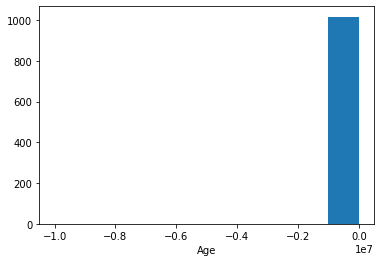

In [35]:
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sysArr = np.array(data.select('Age').collect())
plt.hist(sysArr)
plt.xlabel('Age')
plt.show()

<AxesSubplot:xlabel='Age before cleaning', ylabel='Density'>

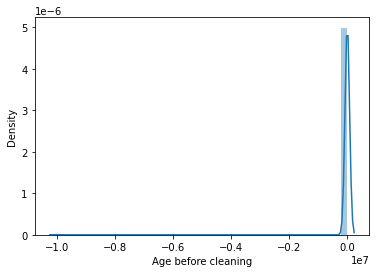

In [38]:
sns.distplot(sysArr, axlabel='Age before cleaning')

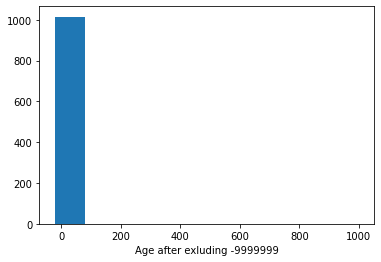

In [39]:
# delete extreme 'Age' value rows
data = data.filter(data.Age!=-9999999)
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sysArr = np.array(data.select('Age').collect())
plt.hist(sysArr)
plt.xlabel('Age after exluding -9999999')
plt.show()

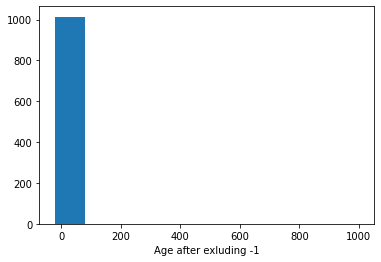

In [40]:
data = data.filter(data.Age!=-1)
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sysArr = np.array(data.select('Age').collect())
plt.hist(sysArr)
plt.xlabel('Age after exluding -1')
plt.show()

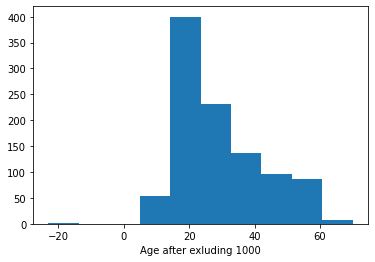

In [41]:
data = data.filter(data.Age!=1000)
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sysArr = np.array(data.select('Age').collect())
plt.hist(sysArr)
plt.xlabel('Age after exluding 1000')
plt.show()

In [42]:
# select 'Age' <= 0 or 'Age' > 100
data.filter((data['Age']<=0) | (data['Age']>100)).show()

+---+----------+-----------+----------+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+---+----------+-----------+----------+--------+---------+---------+
|-23|       130|         70|       6.9|    98.0|       70| mid risk|
+---+----------+-----------+----------+--------+---------+---------+



In [43]:
data.select('Age').dtypes

[('Age', 'int')]

In [44]:
#Replace part of string with another string
data = data.withColumn('Age', regexp_replace('Age', '-23', '23'))

In [45]:
data.select('Age').dtypes

[('Age', 'string')]

In [46]:
# Type cast string column to integer column in pyspark
data = data.withColumn("Age", data["Age"].cast(IntegerType()))

In [47]:
data.select('Age').dtypes

[('Age', 'int')]

In [48]:
data.filter(data.Age==-23).show()

+---+----------+-----------+----------+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+---+----------+-----------+----------+--------+---------+---------+
+---+----------+-----------+----------+--------+---------+---------+



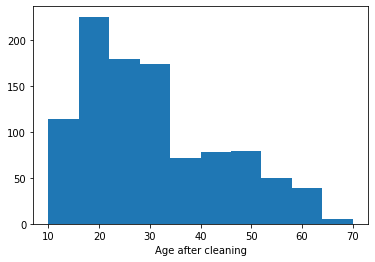

In [49]:
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sysArr = np.array(data.select('Age').collect())
plt.hist(sysArr)
plt.xlabel('Age after cleaning')
plt.show()

<AxesSubplot:xlabel='Age after cleaning', ylabel='Density'>

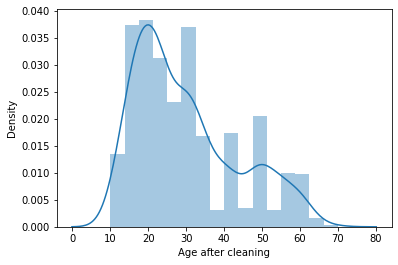

In [50]:
sns.distplot(sysArr, axlabel='Age after cleaning')

In [51]:
# find average 'Age'
data.agg({'Age': 'avg'}).show()

+-----------------+
|         avg(Age)|
+-----------------+
|29.85404339250493|
+-----------------+



<AxesSubplot:xlabel='heartRate before cleaning', ylabel='Density'>

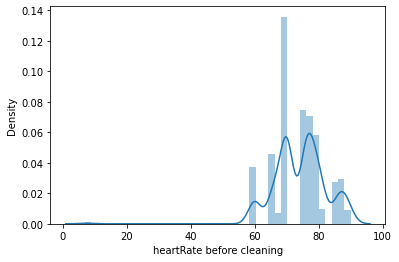

In [52]:
# dist of 'heartRate before cleaning'
sysArr = np.array(data.select('heartRate').collect())
sns.distplot(sysArr, axlabel='heartRate before cleaning')

In [53]:
# exclude extreme 'heartRate' values
data = data.filter(data.heartRate!=7)

In [54]:
data.filter(data.heartRate==7).show()

+---+----------+-----------+----------+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+---+----------+-----------+----------+--------+---------+---------+
+---+----------+-----------+----------+--------+---------+---------+



<AxesSubplot:xlabel='heartRate after cleaning', ylabel='Density'>

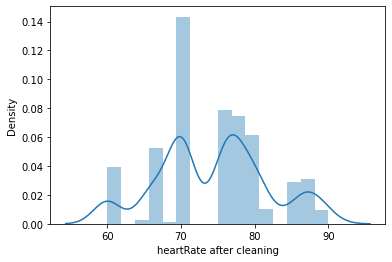

In [55]:
# dist of 'heartRate' after cleaning
sysArr = np.array(data.select('heartRate').collect())
sns.distplot(sysArr, axlabel='heartRate after cleaning')

In [56]:
# description after cleaning
data.describe('Age', 'SystolicBP', 'DiastolicBP', 'bloodsugar', 'bodyTemp', 'heartRate').show()

+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|summary|               Age|        SystolicBP|       DiastolicBP|       bloodsugar|          bodyTemp|        heartRate|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|  count|              1012|              1012|              1012|             1012|              1012|             1012|
|   mean|29.881422924901187|113.15513833992095| 76.43873517786561|8.719812252964427| 98.66442687747035|74.41501976284584|
| stddev|13.458871325636034|18.400550546547663|13.897505329476102|3.291063983088068|1.3748192463115287|7.507180321494286|
|    min|                10|                70|                49|              6.0|              96.0|               60|
|    max|                70|               160|               100|             19.0|             103.0|               90|
+-------+---------------

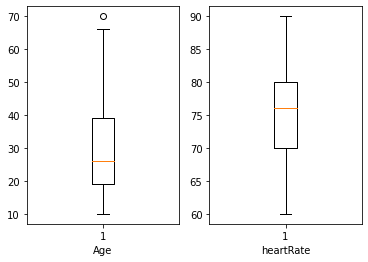

In [57]:
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
aysArr = np.array(data.select('Age').collect())
plt.subplot(1,2,1);
plt.boxplot(aysArr)
plt.xlabel('Age')

# Convert 'heartRate' to an array using Numpy and plot it using pyplot. 
hysArr = np.array(data.select('heartRate').collect())
plt.subplot(1,2,2)
plt.boxplot(hysArr)
plt.xlabel('heartRate')
plt.show()

In [58]:
data.groupby(['riskLevel']).count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
|     High|    1|
|      Low|    1|
| low risk|  403|
|low risk |    1|
| MID RISK|    1|
|HIGH RISK|    1|
| mid risk|  333|
|      Mid|    1|
|mid risk |    1|
|high risk|  269|
+---------+-----+



In [59]:
data.select('*').dtypes

[('Age', 'int'),
 ('SystolicBP', 'int'),
 ('DiastolicBP', 'int'),
 ('bloodsugar', 'double'),
 ('bodyTemp', 'double'),
 ('heartRate', 'int'),
 ('riskLevel', 'string')]

In [60]:
# Type cast in pyspark
data=data.withColumn('Age', data['Age'].cast(DoubleType()))
data=data.withColumn('SystolicBP', data['SystolicBP'].cast(DoubleType()))
data = data.withColumn("DiastolicBP", data["DiastolicBP"].cast(DoubleType()))

In [61]:
data.select('*').dtypes

[('Age', 'double'),
 ('SystolicBP', 'double'),
 ('DiastolicBP', 'double'),
 ('bloodsugar', 'double'),
 ('bodyTemp', 'double'),
 ('heartRate', 'int'),
 ('riskLevel', 'string')]

In [62]:
data.groupby(['riskLevel']).count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
|     High|    1|
|      Low|    1|
| low risk|  403|
|low risk |    1|
| MID RISK|    1|
|HIGH RISK|    1|
| mid risk|  333|
|      Mid|    1|
|mid risk |    1|
|high risk|  269|
+---------+-----+



In [63]:
f=data.where(data.riskLevel.startswith('L'))
f.show()

+----+----------+-----------+----------+--------+---------+---------+
| Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+----+----------+-----------+----------+--------+---------+---------+
|23.0|     100.0|       85.0|       7.1|    98.0|       66|      Low|
+----+----------+-----------+----------+--------+---------+---------+



In [64]:
for i in range(0,f.count()):
    data=data.withColumn('riskLevel', F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], "low risk"))

In [65]:
data.groupby('riskLevel').count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
|     High|    1|
| low risk|  404|
|low risk |    1|
| MID RISK|    1|
|HIGH RISK|    1|
| mid risk|  333|
|      Mid|    1|
|mid risk |    1|
|high risk|  269|
+---------+-----+



In [66]:
f=data.where(data.riskLevel.startswith('M'))
f.show()

+----+----------+-----------+----------+--------+---------+---------+
| Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+----+----------+-----------+----------+--------+---------+---------+
|44.0|     120.0|       90.0|      16.0|    98.0|       80| MID RISK|
|29.0|     130.0|       70.0|       7.5|    98.0|       78|      Mid|
+----+----------+-----------+----------+--------+---------+---------+



In [67]:
for i in range(0, f.count()):
    data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'mid risk')) 

In [68]:
data.groupby('riskLevel').count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
|     High|    1|
| low risk|  404|
|low risk |    1|
|HIGH RISK|    1|
| mid risk|  335|
|mid risk |    1|
|high risk|  269|
+---------+-----+



In [69]:
f=data.where(data.riskLevel.startswith('H'))
f.show()

+----+----------+-----------+----------+--------+---------+---------+
| Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|
+----+----------+-----------+----------+--------+---------+---------+
|34.0|      85.0|       60.0|      11.0|   102.0|       86|HIGH RISK|
|63.0|     140.0|       90.0|      15.0|    98.0|       90|     High|
+----+----------+-----------+----------+--------+---------+---------+



In [70]:
for i in range(0,f.count()):
    data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'high risk')) 

In [71]:
data.groupby(['riskLevel']).count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
| low risk|  404|
|low risk |    1|
| mid risk|  335|
|mid risk |    1|
|high risk|  271|
+---------+-----+



In [72]:
# Remove leading space of the column in pyspark
data=data.withColumn('riskLevel', F.trim(data.riskLevel))
data.groupby(['riskLevel']).count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
| low risk|  405|
| mid risk|  336|
|high risk|  271|
+---------+-----+



<BarContainer object of 3 artists>

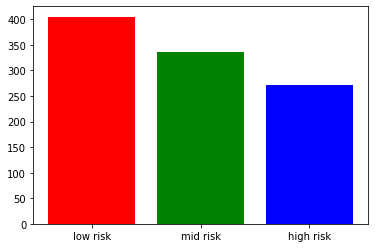

In [73]:
df=data.groupby('riskLevel').count()
df=df.toPandas()
plt.bar(df['riskLevel'].values, df['count'].values, color=['red','green','blue'])

In [74]:
indexer = StringIndexer(inputCol="riskLevel", outputCol="riskLevelIndex")
data = indexer.fit(data).transform(data)

In [75]:
data.groupby('riskLevel').count().show()

+---------+-----+
|riskLevel|count|
+---------+-----+
| low risk|  405|
| mid risk|  336|
|high risk|  271|
+---------+-----+



In [76]:
data.groupby('riskLevelIndex').count().show()

+--------------+-----+
|riskLevelIndex|count|
+--------------+-----+
|           0.0|  405|
|           1.0|  336|
|           2.0|  271|
+--------------+-----+



In [77]:
data.columns

['Age',
 'SystolicBP',
 'DiastolicBP',
 'bloodsugar',
 'bodyTemp',
 'heartRate',
 'riskLevel',
 'riskLevelIndex']

In [78]:
data=data.withColumnRenamed('bloodsugar', 'BS').withColumnRenamed('bodyTemp', 'BodyTemp')
data=data.withColumnRenamed('heartRate', 'HeartRate').withColumnRenamed('riskLevel', 'RiskLevel')
data=data.withColumnRenamed('riskLevelIndex', 'RiskLevelIndex')

In [79]:
data.columns

['Age',
 'SystolicBP',
 'DiastolicBP',
 'BS',
 'BodyTemp',
 'HeartRate',
 'RiskLevel',
 'RiskLevelIndex']

In [80]:
data.select('*').dtypes

[('Age', 'double'),
 ('SystolicBP', 'double'),
 ('DiastolicBP', 'double'),
 ('BS', 'double'),
 ('BodyTemp', 'double'),
 ('HeartRate', 'int'),
 ('RiskLevel', 'string'),
 ('RiskLevelIndex', 'double')]

In [81]:
# data type cast in pyspark
data=data.withColumn('RiskLevelIndex', data['RiskLevelIndex'].cast(IntegerType()))

In [82]:
data.select('*').dtypes

[('Age', 'double'),
 ('SystolicBP', 'double'),
 ('DiastolicBP', 'double'),
 ('BS', 'double'),
 ('BodyTemp', 'double'),
 ('HeartRate', 'int'),
 ('RiskLevel', 'string'),
 ('RiskLevelIndex', 'int')]

In [83]:
assembler = VectorAssembler(
    inputCols=['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate'],
    outputCol="features")

In [84]:
data=assembler.transform(data)
data.show(5)

+----+----------+-----------+----+--------+---------+---------+--------------+--------------------+
| Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|RiskLevelIndex|            features|
+----+----------+-----------+----+--------+---------+---------+--------------+--------------------+
|25.0|     130.0|       80.0|15.0|    98.0|       86|high risk|             2|[25.0,130.0,80.0,...|
|35.0|     140.0|       90.0|13.0|    98.0|       70|high risk|             2|[35.0,140.0,90.0,...|
|29.0|      90.0|       70.0| 8.0|   100.0|       80|high risk|             2|[29.0,90.0,70.0,8...|
|30.0|     140.0|       85.0| 7.0|    98.0|       70|high risk|             2|[30.0,140.0,85.0,...|
|35.0|     120.0|       60.0| 6.1|    98.0|       76| low risk|             0|[35.0,120.0,60.0,...|
+----+----------+-----------+----+--------+---------+---------+--------------+--------------------+
only showing top 5 rows



In [85]:
target=data.select(['RiskLevelIndex']).toPandas()
target[0:5]

,RiskLevelIndex
0,2
1,2
2,2
3,2
4,0


In [86]:
standardScaler=StandardScaler()

standardScaler.setInputCol('features')
model=standardScaler.fit(data)
model.setOutputCol('features_scaled')
data=model.transform(data)

In [87]:
data.select('features').show(5, truncate=False)

+--------------------------------+
|features                        |
+--------------------------------+
|[25.0,130.0,80.0,15.0,98.0,86.0]|
|[35.0,140.0,90.0,13.0,98.0,70.0]|
|[29.0,90.0,70.0,8.0,100.0,80.0] |
|[30.0,140.0,85.0,7.0,98.0,70.0] |
|[35.0,120.0,60.0,6.1,98.0,76.0] |
+--------------------------------+
only showing top 5 rows



In [88]:
data.select('features_scaled').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                 |
+----------------------------------------------------------------------------------------------------------------+
|[1.8575108859522855,7.065005999203148,5.75642880527075,4.557796529353772,71.28209781971117,11.455699252856354]  |
|[2.6005152403331997,7.608467999141851,6.475982405929594,3.9500903254399353,71.28209781971117,9.32440636860401]  |
|[2.1547126277046513,4.891157999448333,5.036875204611906,2.430824815655345,72.73683450990936,10.656464421261724] |
|[2.2290130631427427,7.608467999141851,6.116205605600172,2.1269717136984267,71.28209781971117,9.32440636860401]  |
|[2.6005152403331997,6.521543999264444,4.317321603953062,1.8535039219372005,71.28209781971117,10.123641200198637]|
+-------------------------------------------------------------------------------

<AxesSubplot:xlabel='Age', ylabel='Density'>

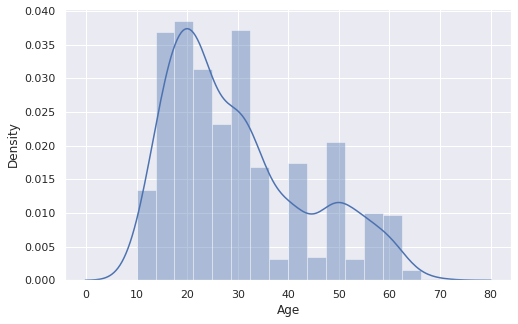

In [96]:
# visualise bar plot of 'Age'
# Convert 'Age' to an array using Numpy and plot it using pyplot. 
sns.set(style='whitegrid', color_codes=True)
sns.set(rc={'figure.figsize': (8, 5)})
sysArr = np.array(data.select('Age').collect())
sns.distplot(sysArr, axlabel='Age')

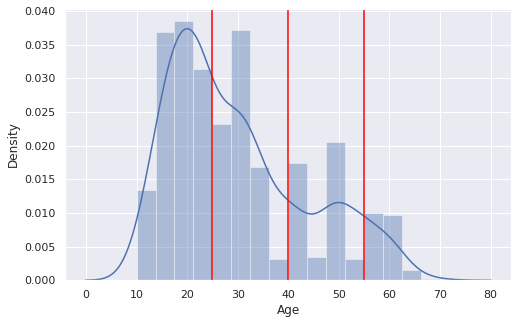

In [97]:
# distribution plot
sysArr = np.array(data.select('Age').collect())
sns.distplot(sysArr, axlabel='Age')
#  Draw vertical line with values
plt.axvline(25, color='red')
plt.axvline(40, color='red')
plt.axvline(55, color='red')

In [98]:
bucketizer = Bucketizer(splits=[ float('-inf'), 31.5, 45, float('Inf') ],
                        inputCol='Age', outputCol="Age_Tier")

df_buck = bucketizer.setHandleInvalid("keep").transform(data)

t = {0.0:"Young", 1.0: "Matured_Young", 2.0:"Middle_Age"}
udf_foo = udf(lambda x: t[x], StringType())
df_buck=df_buck.withColumn("Age_Tier", udf_foo("Age_Tier"))
df_buck.groupby('Age_Tier').count().show()

+-------------+-----+
|     Age_Tier|count|
+-------------+-----+
|   Middle_Age|  182|
|        Young|  636|
|Matured_Young|  194|
+-------------+-----+



Text(0.5, 0, 'Age_Tier')

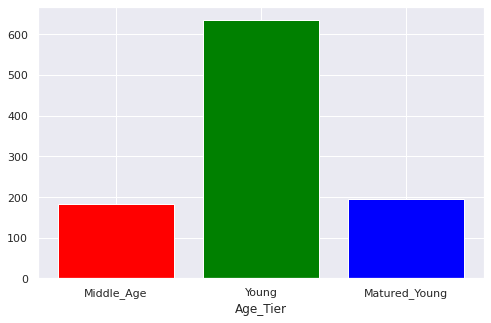

In [99]:
# Plot 'Age_Tier'
df_buck=df_buck.groupby('Age_Tier').count()
df_buck=df_buck.toPandas()
plt.bar(df_buck['Age_Tier'].values, df_buck['count'].values, color=['red', 'green', 'blue'])

plt.xlabel('Age_Tier')

In [100]:
data=data.drop('features')
data.show(5, truncate=False)

+----+----------+-----------+----+--------+---------+---------+--------------+----------------------------------------------------------------------------------------------------------------+
|Age |SystolicBP|DiastolicBP|BS  |BodyTemp|HeartRate|RiskLevel|RiskLevelIndex|features_scaled                                                                                                 |
+----+----------+-----------+----+--------+---------+---------+--------------+----------------------------------------------------------------------------------------------------------------+
|25.0|130.0     |80.0       |15.0|98.0    |86       |high risk|2             |[1.8575108859522855,7.065005999203148,5.75642880527075,4.557796529353772,71.28209781971117,11.455699252856354]  |
|35.0|140.0     |90.0       |13.0|98.0    |70       |high risk|2             |[2.6005152403331997,7.608467999141851,6.475982405929594,3.9500903254399353,71.28209781971117,9.32440636860401]  |
|29.0|90.0      |70.0       |8.0 |100.0 

In [8]:
def data_prep(data):
    #######3.1
    data.filter((data['Age']==-9999999) | (data['Age']==1000) | (data['heartRate']==7))
    # drop the 'comment' column    
    data=data.drop('comment')
    #######3.2.1
    # delete row containing '" "'
    data=data.filter(data.riskLevel!=" ")
    # delete extreme 'Age' value rows
    data = data.filter(data.Age!=-9999999)
    data = data.filter(data.Age!=-1)
    data = data.filter(data.Age!=1000)
    #Replace part of string with another string
    data = data.withColumn('Age', regexp_replace('Age', '-23', '23'))
    # Type cast string column to integer column in pyspark
    data = data.withColumn("Age", data["Age"].cast(IntegerType()))
    # find average 'Age'
    data.agg({'Age': 'avg'})
    # exclude extreme 'heartRate' values
    data = data.filter(data.heartRate!=7)
    ##########3.2.2 Convert data types
    # Type cast in pyspark
    data=data.withColumn('Age', data['Age'].cast(DoubleType()))
    data=data.withColumn('SystolicBP', data['SystolicBP'].cast(DoubleType()))
    data = data.withColumn("DiastolicBP", data["DiastolicBP"].cast(DoubleType()))
    ##########3.2.3 'riskLevel' coding scheme
    # reclassify into "low risk" class
    f=data.where(data.riskLevel.startswith('L'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel', F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], "low risk"))
    # reclassify into "mid risk" class
    f=data.where(data.riskLevel.startswith('M'))
    for i in range(0, f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'mid risk'))
    # reclassify into "high risk" class
    f=data.where(data.riskLevel.startswith('H'))
    for i in range(0,f.count()):
        data=data.withColumn('riskLevel',
                     F.regexp_replace('riskLevel', f.collect()[i]['riskLevel'], 'high risk'))
    # Remove leading space of the column in pyspark
    data=data.withColumn('riskLevel', F.trim(data.riskLevel))
    ########3.2.4 Assign integer values to categorical variables
    indexer = StringIndexer(inputCol="riskLevel", outputCol="riskLevelIndex")
    data = indexer.fit(data).transform(data)
    ########3.2.5 Consistency in Attribute naming
    data=data.withColumnRenamed('bloodsugar', 'BS').withColumnRenamed('bodyTemp', 'BodyTemp')
    data=data.withColumnRenamed('heartRate', 'HeartRate').withColumnRenamed('riskLevel', 'RiskLevel')
    data=data.withColumnRenamed('riskLevelIndex', 'RiskLevelIndex')
    # data type cast in pyspark
    data=data.withColumn('RiskLevelIndex', data['RiskLevelIndex'].cast(IntegerType()))
    ########3.2.6 selecting the target and input variables
    assembler = VectorAssembler(
        inputCols=['Age','SystolicBP','DiastolicBP','BS','BodyTemp','HeartRate'],
        outputCol="features")
    data=assembler.transform(data)
    # target variable
    target=data.select(['RiskLevelIndex']).toPandas()
    ########3.2.7 standardizing the input attribute values
    standardScaler=StandardScaler()
    standardScaler.setInputCol('features')
    model=standardScaler.fit(data)
    model.setOutputCol('features_scaled')
    data=model.transform(data)
    #######3.3 constructing / deriving a new feature
    bucketizer = Bucketizer(splits=[ float('-inf'), 31.5, 45, float('Inf') ],
                            inputCol='Age', outputCol="Age_Tier")
    df_buck = bucketizer.setHandleInvalid("keep").transform(data)
    t = {0.0:"Young", 1.0: "Matured_Young", 2.0:"Middle_Age"}
    udf_foo = udf(lambda x: t[x], StringType())
    df_buck=df_buck.withColumn("Age_Tier", udf_foo("Age_Tier"))
    
    return data

# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
data = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
data = data_prep(data=data)
data.show(5, truncate=False)

+----+----------+-----------+----+--------+---------+---------+--------------+--------------------------------+----------------------------------------------------------------------------------------------------------------+
|Age |SystolicBP|DiastolicBP|BS  |BodyTemp|HeartRate|RiskLevel|RiskLevelIndex|features                        |features_scaled                                                                                                 |
+----+----------+-----------+----+--------+---------+---------+--------------+--------------------------------+----------------------------------------------------------------------------------------------------------------+
|25.0|130.0     |80.0       |15.0|98.0    |86       |high risk|2             |[25.0,130.0,80.0,15.0,98.0,86.0]|[1.8575108859522855,7.065005999203148,5.75642880527075,4.557796529353772,71.28209781971117,11.455699252856354]  |
|35.0|140.0     |90.0       |13.0|98.0    |70       |high risk|2             |[35.0,140.0,90.0,13.0,

In [11]:
# read csv and store
data = spark.read.csv("Maternal Health Risk Data Set.csv",
                      inferSchema=True, header=True)

In [12]:
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- bloodsugar: double (nullable = true)
 |-- bodyTemp: double (nullable = true)
 |-- heartRate: integer (nullable = true)
 |-- riskLevel: string (nullable = true)
 |-- comment: string (nullable = true)



In [177]:
data.show(5)

+---+----------+-----------+----------+--------+---------+---------+----------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [179]:
df1=data.select('Age', 'SystolicBP', 'DiastolicBP', 'bloodsugar')
df1=spark.createDataFrame(df1.toPandas().reset_index()).withColumnRenamed('index', 'ID')
df1.show(5)

+---+---+----------+-----------+----------+
| ID|Age|SystolicBP|DiastolicBP|bloodsugar|
+---+---+----------+-----------+----------+
|  0| 25|       130|         80|      15.0|
|  1| 35|       140|         90|      13.0|
|  2| 29|        90|         70|       8.0|
|  3| 30|       140|         85|       7.0|
|  4| 35|       120|         60|       6.1|
+---+---+----------+-----------+----------+
only showing top 5 rows



In [180]:
df2=data.select('bodyTemp', 'heartRate', 'riskLevel', 'comment')
df2=spark.createDataFrame(df2.toPandas().reset_index()).withColumnRenamed('index', 'ID')
df2.show(5)

+---+--------+---------+---------+----------+
| ID|bodyTemp|heartRate|riskLevel|   comment|
+---+--------+---------+---------+----------+
|  0|    98.0|       86|high risk|no comment|
|  1|    98.0|       70|high risk|no comment|
|  2|   100.0|       80|high risk|no comment|
|  3|    98.0|       70|high risk|no comment|
|  4|    98.0|       76| low risk|no comment|
+---+--------+---------+---------+----------+
only showing top 5 rows



In [194]:
# inner join in pyspark
df_inner=df1.join(df2, on=['ID'], how='inner').orderBy('ID')
df_inner.show(5)

+---+---+----------+-----------+----------+--------+---------+---------+----------+
| ID|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+---+----------+-----------+----------+--------+---------+---------+----------+
|  0| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
|  1| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
|  2| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
|  3| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
|  4| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [198]:
df_inner.drop('ID').show(5)

+---+----------+-----------+----------+--------+---------+---------+----------+
|Age|SystolicBP|DiastolicBP|bloodsugar|bodyTemp|heartRate|riskLevel|   comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
| 25|       130|         80|      15.0|    98.0|       86|high risk|no comment|
| 35|       140|         90|      13.0|    98.0|       70|high risk|no comment|
| 29|        90|         70|       8.0|   100.0|       80|high risk|no comment|
| 30|       140|         85|       7.0|    98.0|       70|high risk|no comment|
| 35|       120|         60|       6.1|    98.0|       76| low risk|no comment|
+---+----------+-----------+----------+--------+---------+---------+----------+
only showing top 5 rows



In [24]:
data.printSchema()

root
 |-- Age: double (nullable = true)
 |-- SystolicBP: double (nullable = true)
 |-- DiastolicBP: double (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)
 |-- RiskLevelIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)



<BarContainer object of 6 artists>

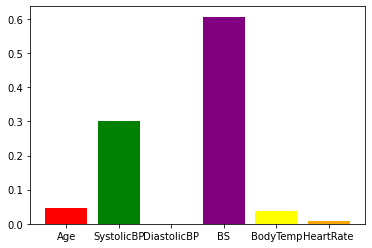

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
import pandas as pd

# Now we will plot a bar graph of standardized 'features' verses 'RiskLevel'
DT = DecisionTreeClassifier(featuresCol="features", labelCol='RiskLevelIndex', seed=4)
DT=DT.fit(data)
# view feature importance in a table
features_imp_pd = (pd.DataFrame(DT.featureImportances.toArray(), index=data.columns[0:6], columns=['importance']))
features_imp_pd
# plot feature importance
new_color = ['red', 'green', 'blue', 'purple', 'yellow', 'orange']
plt.rcParams["figure.figsize"]=(8,4)
plt.bar(data.columns[0:6], DT.featureImportances.toArray(), color=new_color)

In [7]:
# correlation coefficients
cor=[]; col=[]
for i in range(0,6):
    cor.append(data.stat.corr(data.columns[i], 'RiskLevelIndex'))
    col.append(data.columns[i])
pd.DataFrame(cor,col, columns=['correlation coefficient with RiskLevelIndex'])

,correlation coefficient with RiskLevelIndex
Age,0.263775
SystolicBP,0.396500
DiastolicBP,0.346536
BS,0.569161
BodyTemp,0.165693
HeartRate,0.188532


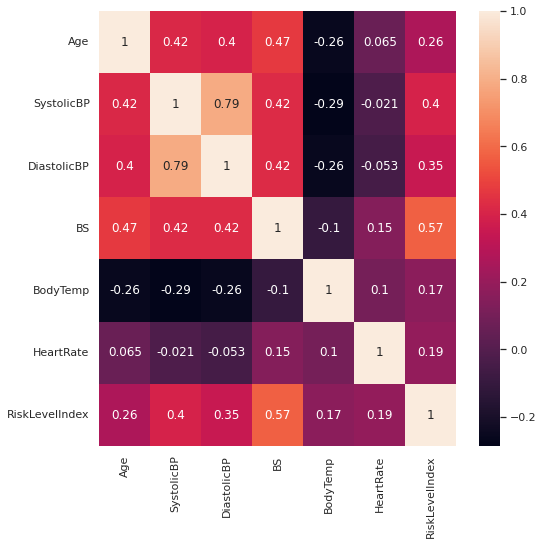

In [48]:
# concatenate the columns to calculate correlation coefficients
data_corr=data.select(data.columns[0:6] + [data.columns[-3]]).toPandas()
# correlation
corr_mat=data_corr.corr()
# plot
sns.set(rc={'figure.figsize': (8, 8)})
sns.heatmap(corr_mat, annot=True)
plt.show()

<AxesSubplot:xlabel='Natural log Age', ylabel='Density'>

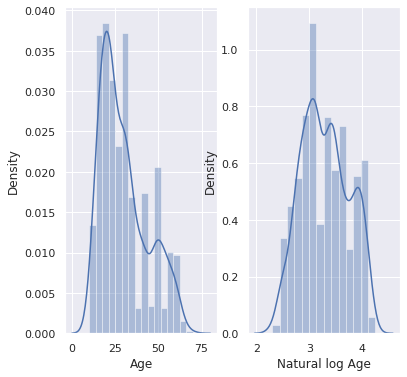

In [70]:
sns.set(rc={'figure.figsize': (6,6)})
# natural log transformation of 'Age'
plt.subplot(1, 2, 1);
sysArr = np.array(data.select('Age').collect())
sns.distplot(sysArr, axlabel='Age')

plt.subplot(1,2,2);
sns.distplot(np.log(sysArr), axlabel='Natural log Age')

<AxesSubplot:xlabel='Natural log SystolicBP', ylabel='Density'>

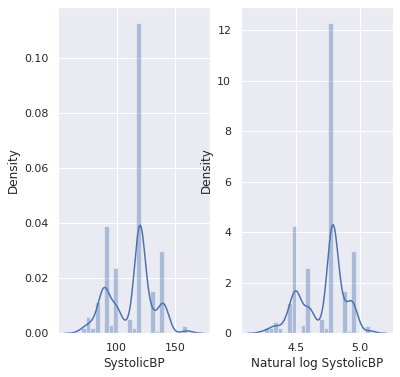

In [71]:
sns.set(rc={'figure.figsize': (6,6)})
# natural log transformation of 'SystolicBP'
plt.subplot(1, 2, 1);
sysArr = np.array(data.select('SystolicBP').collect())
sns.distplot(sysArr, axlabel='SystolicBP')

plt.subplot(1,2,2);
sns.distplot(np.log(sysArr), axlabel='Natural log SystolicBP')

<AxesSubplot:xlabel='Natural log DiastolicBP', ylabel='Density'>

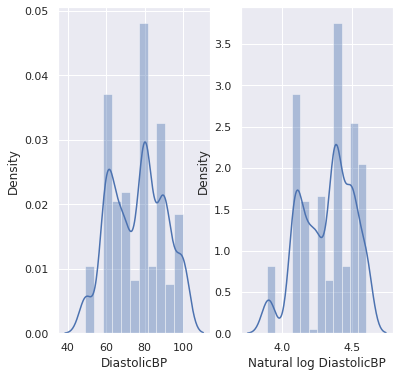

In [72]:
sns.set(rc={'figure.figsize': (6,6)})
# natural log transformation of 'DiastolicBP'
plt.subplot(1, 2, 1);
sysArr = np.array(data.select('DiastolicBP').collect())
sns.distplot(sysArr, axlabel='DiastolicBP')

plt.subplot(1,2,2);
sns.distplot(np.log(sysArr), axlabel='Natural log DiastolicBP')

<AxesSubplot:xlabel='Inverse BS', ylabel='Density'>

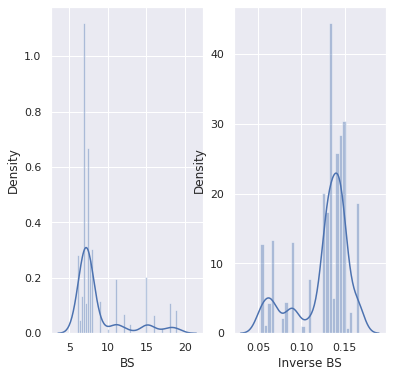

In [76]:
sns.set(rc={'figure.figsize': (6,6)})
# inverse transformation of 'BS'
plt.subplot(1, 2, 1);
sysArr = np.array(data.select('BS').collect())
sns.distplot(sysArr, axlabel='BS')

plt.subplot(1,2,2);
sns.distplot(1/sysArr, axlabel='Inverse BS')

<AxesSubplot:xlabel='Inverse HeartRate', ylabel='Density'>

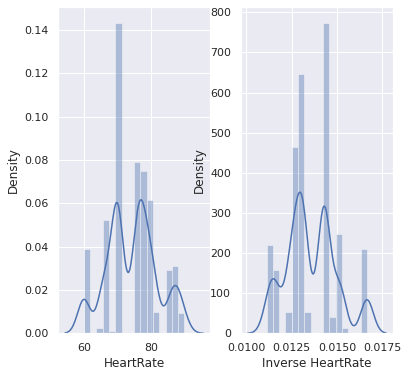

In [77]:
sns.set(rc={'figure.figsize': (6,6)})
# inverse transformation of 'HeartRate'
plt.subplot(1, 2, 1);
sysArr = np.array(data.select('HeartRate').collect())
sns.distplot(sysArr, axlabel='HeartRate')

plt.subplot(1,2,2);
sns.distplot(1/sysArr, axlabel='Inverse HeartRate')

In [7]:
# Use Spark to read in the Maternal Health csv file; you can infer csv schemas.
df = spark.read.csv("Maternal Health Risk Data Set.csv", inferSchema=True, header=True)
df=df.select(df.columns[0:7])
## descriptive statistics of dataframe before cleaning
df.describe().show(truncate=15)

+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------+
|summary|            Age|     SystolicBP|    DiastolicBP|     bloodsugar|       bodyTemp|      heartRate|riskLevel|
+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------+
|  count|           1018|           1018|           1018|           1018|           1018|           1018|     1017|
|   mean|-9792.494106...|113.15618860...|76.415520628...|8.7117583497...|98.654616895...|74.265225933...|     null|
| stddev|313420.50358...|18.349769141...|13.877014050...|3.2831447548...|1.3788126012...|8.0633180717...|     null|
|    min|       -9999999|             70|             49|            6.0|           96.0|              7|HIGH RISK|
|    max|           1000|            160|            100|           19.0|          103.0|             90|mid risk |
+-------+---------------+---------------+---------------+---------------

In [10]:
data.show(5, truncate=15)

+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
| Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|RiskLevelIndex|       features|features_scaled|
+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
|25.0|     130.0|       80.0|15.0|    98.0|       86|high risk|             2|[25.0,130.0,...|[1.857510885...|
|35.0|     140.0|       90.0|13.0|    98.0|       70|high risk|             2|[35.0,140.0,...|[2.600515240...|
|29.0|      90.0|       70.0| 8.0|   100.0|       80|high risk|             2|[29.0,90.0,7...|[2.154712627...|
|30.0|     140.0|       85.0| 7.0|    98.0|       70|high risk|             2|[30.0,140.0,...|[2.229013063...|
|35.0|     120.0|       60.0| 6.1|    98.0|       76| low risk|             0|[35.0,120.0,...|[2.600515240...|
+----+----------+-----------+----+--------+---------+---------+--------------+---------------+---------------+
o

In [15]:
# data.select variables
data_cleaned=data.select(data.columns[0:6] + [data.columns[7]])
# descriptive statistics of dataframe after cleaning
data_cleaned.describe().show(5, truncate=15)

+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|summary|            Age|     SystolicBP|    DiastolicBP|             BS|       BodyTemp|      HeartRate| RiskLevelIndex|
+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|  count|           1012|           1012|           1012|           1012|           1012|           1012|           1012|
|   mean|29.881422924...|113.15513833...|76.438735177...|8.7198122529...|98.664426877...|74.415019762...|0.8675889328...|
| stddev|13.458871325...|18.400550546...|13.897505329...|3.2910639830...|1.3748192463...|7.5071803214...|0.8069045007...|
|    min|           10.0|           70.0|           49.0|            6.0|           96.0|             60|              0|
|    max|           70.0|          160.0|          100.0|           19.0|          103.0|             90|              2|
+-------+---------------

<AxesSubplot:xlabel='Age after cleaning', ylabel='Density'>

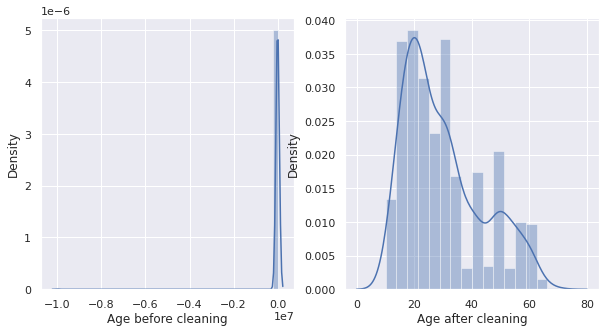

In [24]:
# create an array of 'Age' variable before and after cleaning
sysArr_raw=np.array(df.select('Age').collect())
sysArr_clean=np.array(data.select('Age').collect())
# distribution plot of 'Age'
sns.set(rc={'figure.figsize': (10,5)})
plt.subplot(1,2,1); sns.distplot(sysArr_raw, axlabel='Age before cleaning')
plt.subplot(1,2,2); sns.distplot(sysArr_clean, axlabel='Age after cleaning')

<AxesSubplot:xlabel='HeartRate after cleaning', ylabel='Density'>

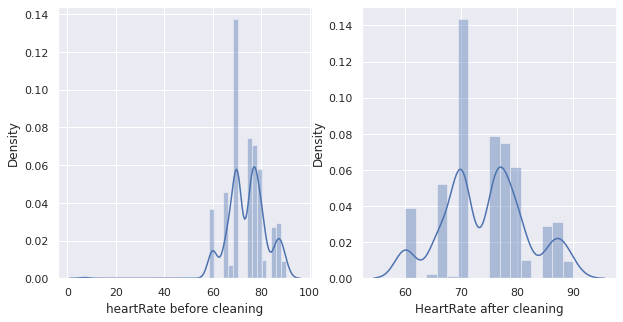

In [27]:
# create an Array of 'HeartRate' values before and after cleaning
sysArr_raw = np.array(df.select('heartRate').collect())
sysArr_clean=np.array(data.select('HeartRate').collect())
# distribution plot
plt.subplot(1,2,1); sns.distplot(sysArr_raw, axlabel='heartRate before cleaning')
plt.subplot(1,2,2); sns.distplot(sysArr_clean, axlabel='HeartRate after cleaning')

[Text(0.5, 0, 'RiskLevel after cleaning'), Text(0, 0.5, 'count')]

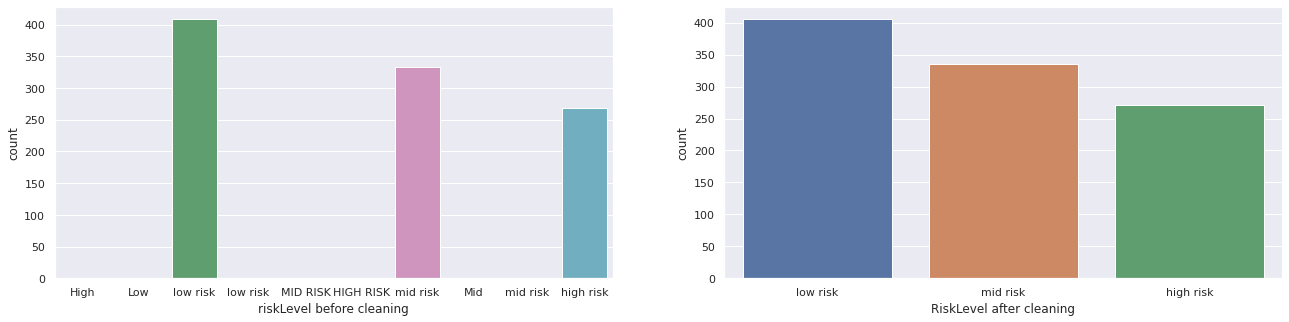

In [39]:
# collect data
df_raw=df.groupby('riskLevel').count(); df_raw=df_raw.toPandas()
data_clean=data.groupby('RiskLevel').count(); data_clean=data_clean.toPandas()
# bar chart
sns.set(rc={'figure.figsize': (22,5)})
plt.subplot(1,2,1) 
ax = sns.barplot(df_raw['riskLevel'].values, df_raw['count'].values)#, axlabel=)
ax.set(xlabel='riskLevel before cleaning', ylabel='count')
       
plt.subplot(1,2,2)
ax=sns.barplot(data_clean['RiskLevel'].values, data_clean['count'].values)
ax.set(xlabel='RiskLevel after cleaning', ylabel='count')